# PM2.5 Forecast - RNN Models


## Dataset
The data collected for time series analysis and prediction with VAR and AR were from Dec 1, 2021 to Jan 5, 2022. As it was hourly measured, there were 864 rows in total with 815 rows (with differencing level 1) for training and 48 rows for testing. Then, the dataset was updated to Feb 23, 2022 09:00:00 in order to train with RNN model.

## RNN Models
The RNN models used to train and predict PM2.5 are as followings:
1. Simple RNN model 
2. GRU model
3. LSTM model


## Import libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN, GRU
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os
%matplotlib inline

from statsmodels.tools.eval_measures import rmse

2022-03-03 06:02:17.764845: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-03 06:02:17.764874: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# Reproduce
SEED = 22
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2022-03-03 06:02:23.353848: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-03 06:02:23.362011: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-03 06:02:23.362358: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-03 06:02:23.362433: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jabib-Lenovo-ideapad-700-15ISK): /proc/driver/nvidia/version does not exist


## Import Data and Data Preparation

In [3]:
data = pd.read_csv('cleaned_dataset_updated.csv')

In [4]:
data.head()

,datetime,PM2.5,PM10,O3,CO,NO2
0,2021-12-01 00:00:00,32,79,18.0,1.28,32.0
1,2021-12-01 01:00:00,27,78,19.0,1.23,29.0
2,2021-12-01 02:00:00,25,74,21.0,1.22,25.0
3,2021-12-01 03:00:00,33,72,30.0,1.15,18.0
4,2021-12-01 04:00:00,40,66,19.0,1.23,26.0


In [5]:
data['datetime'] = pd.to_datetime(data["datetime"])
data.set_index('datetime', inplace=True)
data.index.freq = 'H'

In [6]:
data.head()

,PM2.5,PM10,O3,CO,NO2
datetime,,,,,
2021-12-01 00:00:00,32,79,18.0,1.28,32.0
2021-12-01 01:00:00,27,78,19.0,1.23,29.0
2021-12-01 02:00:00,25,74,21.0,1.22,25.0
2021-12-01 03:00:00,33,72,30.0,1.15,18.0
2021-12-01 04:00:00,40,66,19.0,1.23,26.0


In [7]:
len(data)

2026

In [8]:
pm25 = data['PM2.5'].values.reshape(-1,1)
pm25.shape

(2026, 1)

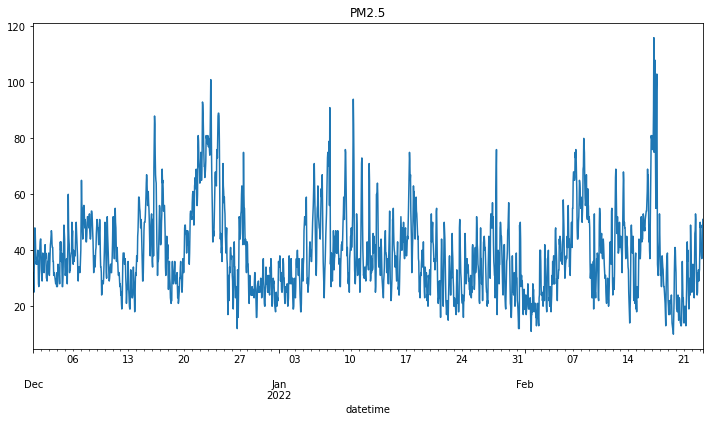

In [9]:
data['PM2.5'].plot(figsize=(12,6))
plt.title("PM2.5");

# Deep Learning Model Training

## Train/ Test Split
The dataset was divided into Train/Test set at 80:20 ratio.

## Data Regularization

In [10]:
TRAIN_SPLIT = int(len(pm25)*0.8)
BATCH_SIZE = 128

In [11]:
# check training data mean
x_train_mean = pm25[:TRAIN_SPLIT].mean()
x_train_std = pm25[:TRAIN_SPLIT].std()

In [12]:
x_train_mean

38.54567901234568

In [13]:
scaled_pm25 = (pm25 - x_train_mean)/x_train_std

In [14]:
len(scaled_pm25)

2026

## Generator Function

In [15]:
def generator(dataset, start_index, end_index, history_size, target_size, single_step=False):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
    
        # Reshape data from (history_size,) to (history_size,1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        if single_step:
            labels.append(dataset[i + target_size])
        else:
            labels.append(dataset[i: i + target_size])
    return np.array(data), np.array(labels)

## Generate Train/Test Sets
The training batches including input data with the same intervals and their target value were generated.  

In [16]:
n_past = 3*24 # 3 days * 24 hours
n_future = 2*24 # 2 days * 24 hours
x_train, y_train = generator(scaled_pm25, start_index=0, end_index=TRAIN_SPLIT, 
                            history_size=n_past, target_size=n_future)
x_test, y_test = generator(scaled_pm25, start_index=TRAIN_SPLIT, end_index=None, 
                           history_size=n_past, target_size=n_future)

In [17]:
x_train.shape

(1548, 72, 1)

In [18]:
y_train.shape

(1548, 48, 1)

In [19]:
x_test.shape

(286, 72, 1)

In [20]:
y_test.shape

(286, 48, 1)

In [21]:
# check the first sample
sample_x, sample_y = x_train[0], y_train[0]
print('Given data: {}'.format(sample_x.flatten()))
print('Target: {}'.format(sample_y.flatten()))

Given data: [-0.45706298 -0.80619633 -0.94584968 -0.38723631  0.10155039  0.66016376
  0.59033709  0.24120374 -0.10792962 -0.24758296 -0.17775629 -0.24758296
 -0.10792962 -0.03810295  0.10155039 -0.17775629 -0.73636966 -0.80619633
 -0.66654299 -0.45706298  0.10155039  0.31103041  0.38085708  0.38085708
  0.03172372 -0.38723631 -0.52688965 -0.66654299 -0.24758296  0.03172372
 -0.24758296 -0.17775629 -0.24758296 -0.45706298 -0.10792962 -0.03810295
  0.24120374 -0.10792962  0.03172372 -0.24758296 -0.59671632 -0.59671632
 -0.66654299 -0.38723631 -0.17775629 -0.17775629 -0.03810295  0.03172372
 -0.45706298 -0.52688965 -0.24758296  0.03172372  0.24120374  0.31103041
  0.45068375  0.59033709  0.52051042  0.24120374  0.17137706  0.17137706
 -0.17775629 -0.17775629 -0.52688965 -0.45706298 -0.45706298 -0.52688965
 -0.59671632 -0.66654299 -0.73636966 -0.66654299 -0.59671632 -0.80619633]
Target: [-0.45706298 -0.80619633 -0.66654299 -0.24758296 -0.31740963 -0.45706298
 -0.45706298 -0.52688965 -0.73

## RNN Model

1. Simple RNN Model
2. GRU Model
3. LSTM Model

### 1. Simple RNN Model

In [22]:
# Create RNN model
model = Sequential()
model.add(SimpleRNN(units=64, kernel_regularizer= l2(0.01),
               return_sequences=True, input_shape = (x_train.shape[1], x_train.shape[2])))
model.add(SimpleRNN(units=64, kernel_regularizer= l2(0.01),
                return_sequences=True))
model.add(SimpleRNN(units=64, kernel_regularizer= l2(0.01)))
model.add(Dense(units = 48))
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.0001), 
              loss='mse')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 72, 64)            4224      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 72, 64)            8256      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 48)                3120      
                                                                 
Total params: 23,856
Trainable params: 23,856
Non-trainable params: 0
_________________________________________________________________


In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [24]:
# prepared train and test batches
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(x_train.shape[0]).batch(BATCH_SIZE).repeat()

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(BATCH_SIZE).repeat()

In [25]:
# take a look for batch, input and output shape
for x, y in train_data.take(1):
    print(x.shape)
    print(x[0].shape)
    print(y[0].shape)

(128, 72, 1)
(72, 1)
(48, 1)


In [26]:
model_history = model.fit(train_data, epochs=20, steps_per_epoch=200,
                          validation_data = test_data, validation_steps=200,
                          callbacks=[early_stopping])

Epoch 1/20
200/200 [==============================] - 15s 69ms/step - loss: 2.1563 - val_loss: 2.6385
Epoch 2/20
200/200 [==============================] - 14s 71ms/step - loss: 1.7655 - val_loss: 2.5735
Epoch 3/20
200/200 [==============================] - 15s 73ms/step - loss: 1.5412 - val_loss: 2.6384
Epoch 4/20
200/200 [==============================] - 15s 74ms/step - loss: 1.3953 - val_loss: 2.6351
Epoch 5/20
200/200 [==============================] - 14s 71ms/step - loss: 1.2887 - val_loss: 2.6151


In [27]:
def plot_train_loss(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    
    plt.figure(figsize=(8,6))
    plt.plot(epochs, loss, 'b', label="Training Loss")
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(title)
    plt.legend()
    plt.show()

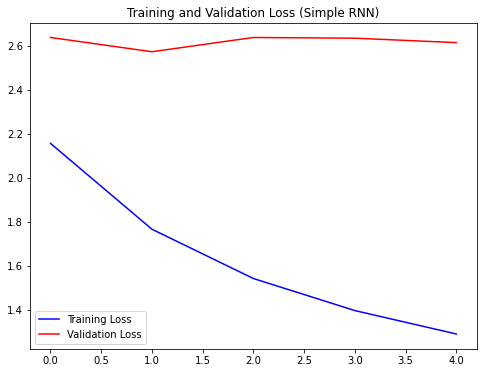

In [28]:
plot_train_loss(model_history, "Training and Validation Loss (Simple RNN)")

In [29]:
def plot_val_predict(history, true_future, prediction):
    plt.figure(figsize=(12,5))
    num_in = list(range(-len(history),0))
    
    num_out = len(true_future)
 
    
    plt.plot(num_in, np.array(history), label='Past')
    plt.plot(np.arange(num_out), np.array(true_future), 'b', markersize=3, label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction), 'r', markersize=3, label='Predicted Future')
    plt.legend(loc='best')
    plt.show()

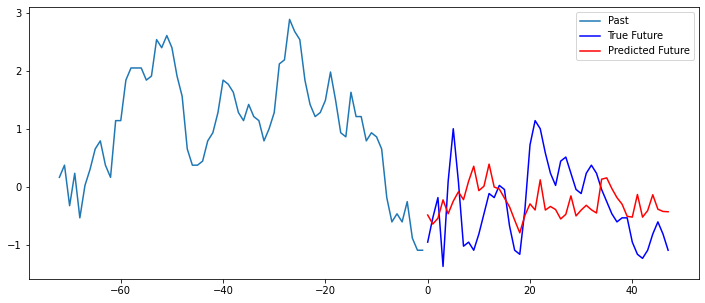

RMSE: 
9.925967374416663


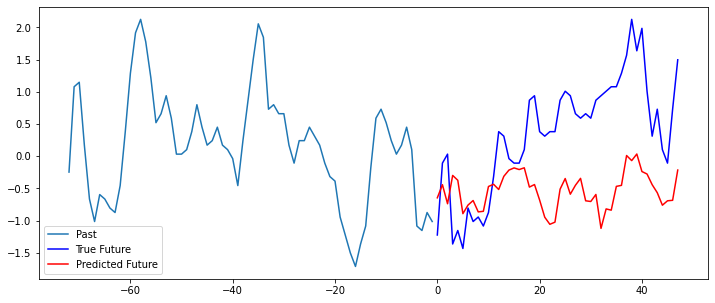

RMSE: 
18.031992783782755


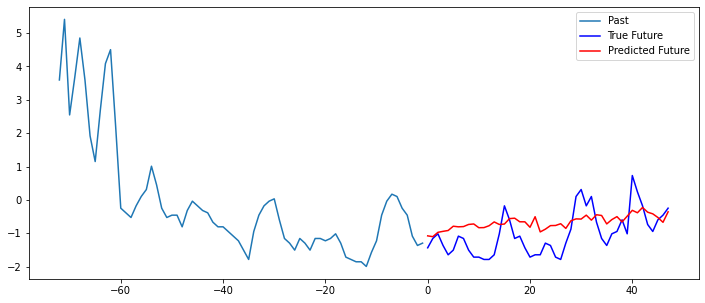

RMSE: 
10.560676052758765


In [30]:
for x, y in test_data.take(3):
    plot_val_predict(x[0], y[0], model.predict(x)[0])
    y_true_inverse = (y[0] * x_train_std) + x_train_mean
    y_pred_inverse = (model.predict(x)[0] * x_train_std) + x_train_mean
    print("RMSE: ")
    tf.print(tf.reduce_mean(rmse(y_true_inverse, y_pred_inverse)))

### 2. GRU Model

In [31]:
model2 = Sequential()
model2.add(GRU(units=64, return_sequences=True, kernel_regularizer=l2(0.01), input_shape = (x_train.shape[1], x_train.shape[2])))
model2.add(GRU(64, return_sequences=True, kernel_regularizer=l2(0.01)))
model2.add(GRU(64, kernel_regularizer=l2(.01)))
model2.add(Dense(units=48))

model2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.0001), 
              loss='mse')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 72, 64)            12864     
                                                                 
 gru_1 (GRU)                 (None, 72, 64)            24960     
                                                                 
 gru_2 (GRU)                 (None, 64)                24960     
                                                                 
 dense_1 (Dense)             (None, 48)                3120      
                                                                 
Total params: 65,904
Trainable params: 65,904
Non-trainable params: 0
_________________________________________________________________


In [32]:
model2_history = model2.fit(train_data, epochs=20, steps_per_epoch=200,
                          validation_data = test_data, validation_steps=200,
                          callbacks=[early_stopping])

Epoch 1/20
200/200 [==============================] - 44s 194ms/step - loss: 2.5512 - val_loss: 2.8209
Epoch 2/20
200/200 [==============================] - 33s 167ms/step - loss: 1.9205 - val_loss: 2.3324
Epoch 3/20
200/200 [==============================] - 29s 145ms/step - loss: 1.5025 - val_loss: 2.0013
Epoch 4/20
200/200 [==============================] - 27s 137ms/step - loss: 1.2194 - val_loss: 1.7807
Epoch 5/20
200/200 [==============================] - 28s 139ms/step - loss: 1.0340 - val_loss: 1.6463
Epoch 6/20
200/200 [==============================] - 32s 159ms/step - loss: 0.9251 - val_loss: 1.6119
Epoch 7/20
200/200 [==============================] - 30s 151ms/step - loss: 0.8609 - val_loss: 1.6178
Epoch 8/20
200/200 [==============================] - 30s 149ms/step - loss: 0.8130 - val_loss: 1.5887
Epoch 9/20
200/200 [==============================] - 31s 154ms/step - loss: 0.7778 - val_loss: 1.6990
Epoch 10/20
200/200 [==============================] - 31s 155ms/step - l

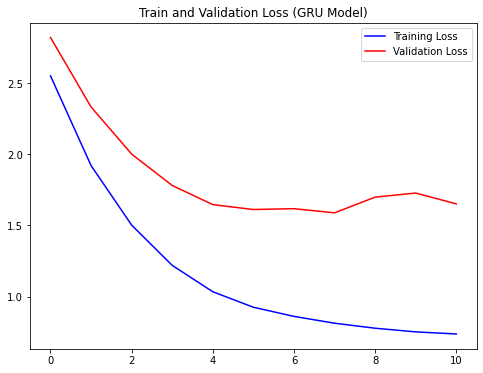

In [33]:
plot_train_loss(model2_history, "Train and Validation Loss (GRU Model)")

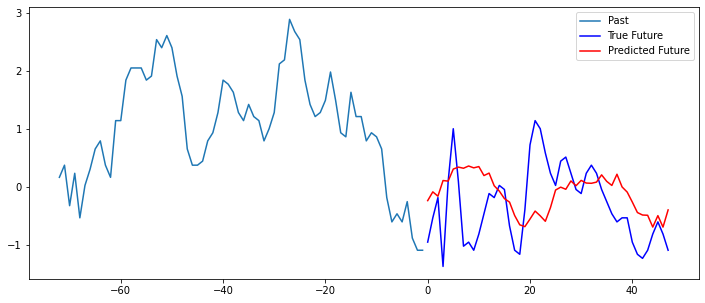

RMSE: 
10.589928051237715


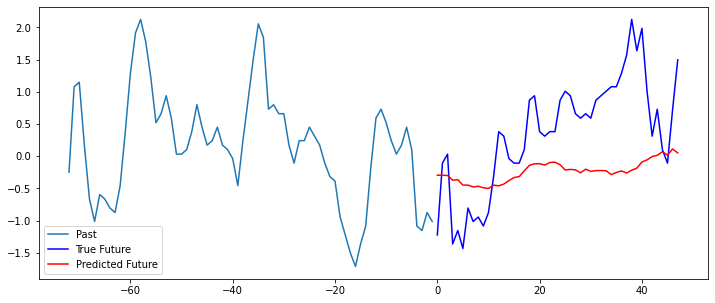

RMSE: 
15.199979492380526


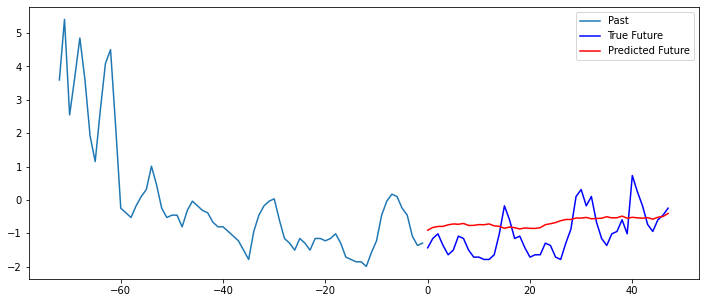

RMSE: 
10.37179710625732


In [34]:
for x, y in test_data.take(3):
    plot_val_predict(x[0], y[0], model2.predict(x)[0])
    y_true_inverse = (y[0] * x_train_std) + x_train_mean
    y_pred_inverse = (model2.predict(x)[0] * x_train_std) + x_train_mean
    print("RMSE: ")
    tf.print(tf.reduce_mean(rmse(y_true_inverse, y_pred_inverse)))

### 3. LSTM Model

In [35]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, kernel_regularizer= l2(0.01),
               return_sequences=True, input_shape = (x_train.shape[1], x_train.shape[2])))
lstm_model.add(LSTM(units=64, kernel_regularizer= l2(0.01),
                return_sequences=True))
lstm_model.add(LSTM(units=64, kernel_regularizer= l2(0.01)))
lstm_model.add(Dense(units = 48))
lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.0001), 
              loss='mse')
lstm_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 72, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 72, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 48)                3120      
                                                                 
Total params: 86,064
Trainable params: 86,064
Non-trainable params: 0
_________________________________________________________________


In [36]:
lstm_history = lstm_model.fit(train_data, epochs=20, steps_per_epoch=200,
                                validation_data = test_data, validation_steps=200,
                                callbacks=[early_stopping])

Epoch 1/20
200/200 [==============================] - 47s 214ms/step - loss: 2.6244 - val_loss: 2.8815
Epoch 2/20
200/200 [==============================] - 37s 187ms/step - loss: 1.8874 - val_loss: 2.5472
Epoch 3/20
200/200 [==============================] - 36s 180ms/step - loss: 1.4120 - val_loss: 2.3930
Epoch 4/20
200/200 [==============================] - 35s 174ms/step - loss: 1.1191 - val_loss: 2.2807
Epoch 5/20
200/200 [==============================] - 44s 221ms/step - loss: 0.9497 - val_loss: 2.2134
Epoch 6/20
200/200 [==============================] - 41s 206ms/step - loss: 0.8556 - val_loss: 2.0912
Epoch 7/20
200/200 [==============================] - 41s 203ms/step - loss: 0.8022 - val_loss: 2.0950
Epoch 8/20
200/200 [==============================] - 39s 194ms/step - loss: 0.7662 - val_loss: 2.0100
Epoch 9/20
200/200 [==============================] - 35s 175ms/step - loss: 0.7303 - val_loss: 2.1976
Epoch 10/20
200/200 [==============================] - 35s 177ms/step - l

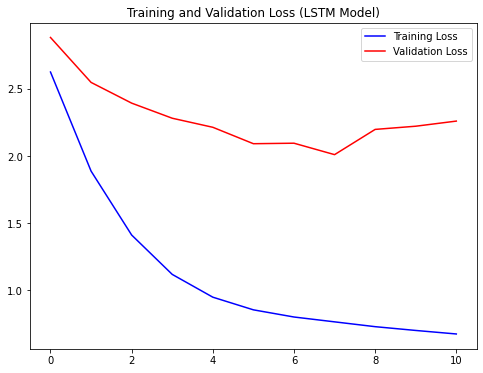

In [37]:
plot_train_loss(lstm_history, "Training and Validation Loss (LSTM Model)")

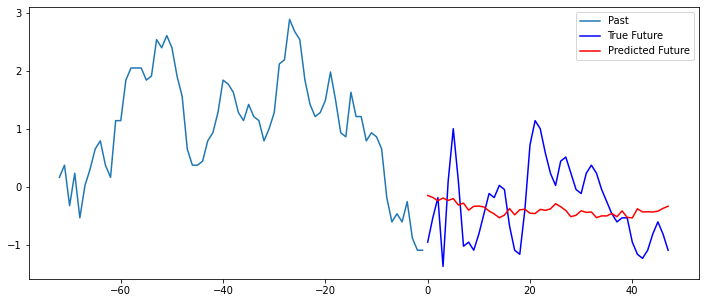

RMSE: 
9.4619662611443189


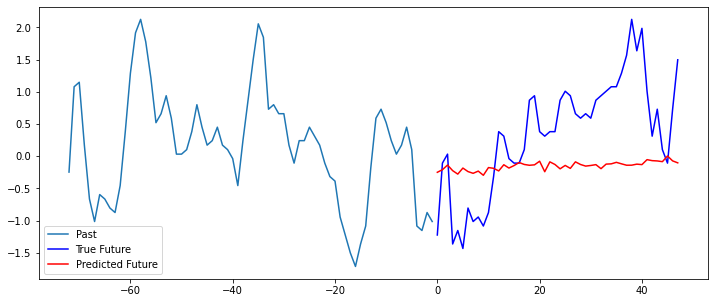

RMSE: 
14.475813786849111


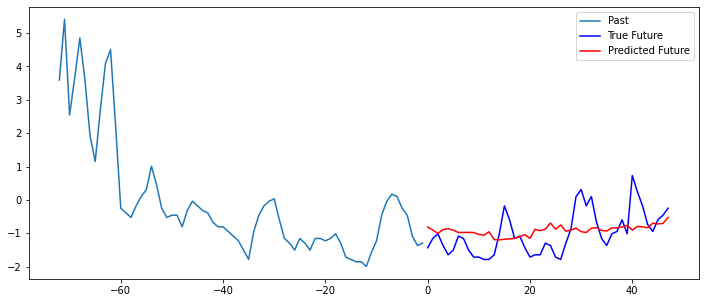

RMSE: 
9.3956272792987416


In [38]:
for x, y in test_data.take(3):
    plot_val_predict(x[0], y[0], lstm_model.predict(x)[0])
    y_true_inverse = (y[0] * x_train_std) + x_train_mean
    y_pred_inverse = (lstm_model.predict(x)[0] * x_train_std) + x_train_mean
    print("RMSE: ")
    tf.print(tf.reduce_mean(rmse(y_true_inverse, y_pred_inverse)))

# Summary
- All the RNN models did not generalized well. Many regularization methods were done, however there was no improvement in the results.
- The predictions from LSTM model is better than the other two models in this scenario.